In [22]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm

In [23]:
def extract_terms(f,t,uI,uII):
    eps=1e-8
    d = len(uII)
    f_base = f(t, uI, uII)
    J = np.zeros((np.atleast_1d(f_base).shape[0], d))
    for i in range(d):
        uII_eps = np.array(uII, dtype=float)
        uII_eps[i] += eps
        diff = (f(t, uI, uII_eps) - f_base) / eps
        J[:, i] = diff.flatten()
    a1 = J
    a0 = f_base - a1 @ uII
    return a0, a1

## Lorenz96 Nudging algorithm on observations with CGKF 

In [24]:
def lorenz96(x, F=8):
    N = len(x)
    dx = np.zeros(N)
    for k in range(N):
        dx[k] = (x[(k+1)%N] - x[k-2]) * x[k-1] - x[k] + F
    return dx

## Single scale

### set up

In [4]:
def make_truth_and_obs(N, F_forcing=8.0, T=10.0, dt=0.01, obs_indices=None, obs_noise_std=0.5, seed=0):
    np.random.seed(seed)
    t = np.arange(0, T+1e-12, dt)
    M = t.size
    # generate truth with solve_ivp (RK45)
    def rhs(t_, y):
        return lorenz96(y, F_forcing)
    x0 = F_forcing * np.ones(N)  # typical L96 initial guess
    x0[int(np.ceil(N/2))] += 0.01  # small perturbation
    sol = solve_ivp(rhs, [0, T], x0, t_eval=t, method="DOP853", rtol=1e-8, atol=1e-10)
    truth = sol.y.T  # shape (M, N)

    if obs_indices is None:
        # observe every other variable as an example
        obs_indices = np.arange(0, N, 2)

    obs_times = t.copy()
    obs_values = truth[:, obs_indices].copy()
    # add Gaussian noise to observations
    obs_values += np.random.normal(0.0, obs_noise_std, size=obs_values.shape)

    return t, truth, obs_times, obs_values, obs_indices


In [5]:
T = 10
N = 6
n = 10000
dt = T / (n-1)
obs_idx = [0,1,3,4]         # indices of observed variables
hid_idx = [i for i in range(N) if i not in obs_idx]  # hidden variables

t, truth, obs_t, obs_vals, obs_idx = make_truth_and_obs(N=N, F_forcing=8.0, T=10.0, dt=dt,
                                                       obs_indices=obs_idx, obs_noise_std=0.5)
uI = truth[obs_idx]    
uII = truth[hid_idx]  

In [8]:
def lorenz96(x, F=8):
    N = len(x)
    dx = np.zeros(N)
    for k in range(N):
        dx[k] = (x[(k+1)%N] - x[k-2]) * x[k-1] - x[k] + F
    return dx
def kb_nudging1(d_uI, d_uII, t_span, uI, uII_0, obs_idx, hid_idx, R0=None, SigmaI=None, SigmaII=None,dt = None, k = 10):
    """ Implementation of dynamic nudging for conditionally Gaussian systems

        Args:
            d_uI: function that returns the observation derivative given the state and input
            d_uII: function that returns the unknown state derivative given the state and input
            t_span: time span for the simulation
            uI: observed state
            uII_0: initial unknown state
            R0: initial covariance matrix (optional)
            SigmaI: process noise covariance matrix (optional)
            SigmaII: measurement noise covariance matrix (optional)
            dt: time step (optional, defaults to None, which will be calculated based on the length of x and t_span)
            k: nudging constant toward observations
        Returns:
            A dictionary containing:
                - t: time values
                - uII: estimated state values
                - R: covariance matrix values
    """

    
    t0, tf = t_span
    n = len(uI)
    d1 = len(uI[0])
    d = len(uII_0)
    t_vals = np.linspace(t0, tf, n)
    dt = (tf - t0) / (n-1) if dt is None else dt
    # uII = np.zeros((d, n))
    # uII[:,0] = uII_0
    u = np.zeros((d+d1,n))
    u[obs_idx,0] = uI[0]
    u[hid_idx,0] = uII_0
    R = np.zeros((n, d, d))
    R[0] = np.eye(d) if R0 is None else R0

    # alpha = .02
    # beta2 = .001
    # m = len(uI[0])
    if SigmaI is not None:
        sst = SigmaI@SigmaI.T
        Sig_inv = np.linalg.inv(sst + np.eye(sst.shape[0])*1e-8 )
    else: 
        Sig_inv = np.zeros((len(uI[0]), len(uI[0])))

    if SigmaII is not None:
        Sigma2 = SigmaII@SigmaII.T
    else: 
        Sigma2 = np.zeros((d, d))
    obs = uI.copy()
    filtered_obs = obs.copy()


    for i in tqdm(range(1, n)):
        # R_inv = np.linalg.inv(R[i-1])
        # diag_inv = np.diag(R_inv)

        K_nudging = np.zeros(d1+d)

        u_prev = u[:,i-1]

        # nudging on observations
        K_nudging[obs_idx] = k
        K_nudging[hid_idx] = 0
        Hu = u_prev.copy()
        Hu[hid_idx] = 0
        obs = Hu.copy()
        obs[obs_idx] = uI[i-1]

        F = lorenz96(u_prev)
        u[:,i] = u[:,i-1] + dt*(F + K_nudging*(obs - Hu))

        # CGKF on hidden variables
        A0,A1 = extract_terms(d_uI, t_vals[i-1], u[obs_idx,i-1], u[hid_idx,i-1])
        a0, a1 = extract_terms(d_uII, t_vals[i-1], u[obs_idx,i-1], u[hid_idx,i-1])
        duI = d_uI(t_vals[i-1],u[obs_idx,i-1],u[hid_idx,i-1])

        # duI = (uI[i] - uI[i-1])/dt
        innovation = duI - (A0 + (A1 @ u[hid_idx,i-1]))
        
        K = (R[i-1] @ A1.T) @ Sig_inv

        u[hid_idx,i] = u[hid_idx,i-1] + dt*((a1@u[hid_idx,i-1] + a0) + (K @ innovation))
        R[i] = R[i-1] + (a1@R[i-1] + R[i-1]@ a1.T  + Sigma2 - R[i-1]@A1.T@Sig_inv@A1@R[i-1])*dt
        if np.isnan(R).any():
            print(f"NaN detected at step {i}, filtering failed")

    return {"t": t_vals, "uI": u[obs_idx,:], "uII": u[hid_idx, :], "R": R}

Text(0.5, 1.0, 'Single Scale Lorenz-96 Observed States')

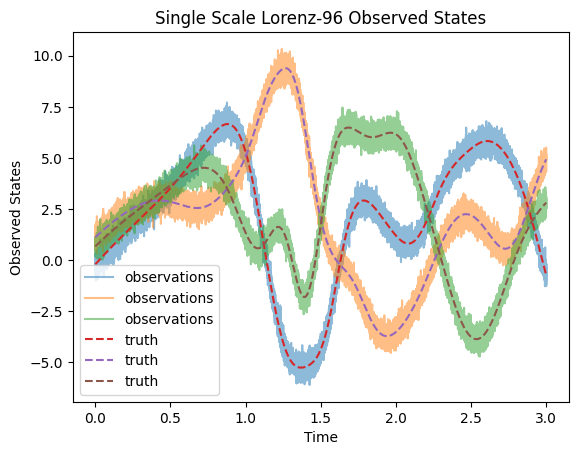

In [39]:
N = 9
F = 8
T = 3
n = 30000
x = np.random.randn(N)
dt = T / (n-1)
x_traj = np.zeros((n, N))
x_traj[0] = x
for i in range(1, n):
    # get true Lorenz-96 trajectory
    x_traj[i] = x_traj[i-1] + lorenz96(x_traj[i-1], F) * dt

uI_traj = x_traj[:, obs_idx] + 0.3 * np.random.randn(len(t), len(obs_idx))

plt.plot(t, uI_traj, label = 'observations', alpha = .5)
plt.plot(t, x_traj[:, obs_idx], '--', label = 'truth')
plt.xlabel("Time")
plt.legend()
plt.ylabel("Observed States")
plt.title("Single Scale Lorenz-96 Observed States")

In [42]:


obs_idx = np.array([0,3,6])         # indices of observed variables
hid_idx = np.array([i for i in range(N) if i not in obs_idx])  # hidden variables

uI = x[obs_idx]    
uII = x[hid_idx]  

def f_uI(t, uI, uII, obs_idx = obs_idx, hid_idx = hid_idx, F=8):
    """Derivative of observed variables, expressed as function of uII."""
    N = len(uI) + len(uII)
    x_full = np.zeros(N)
    x_full[obs_idx] = uI
    x_full[hid_idx] = uII
    dx_full = lorenz96(x_full, F)
    return dx_full[obs_idx]

def f_uII(t, uI, uII, obs_idx = obs_idx, hid_idx = hid_idx, F=8):
    """Derivative of hidden variables."""
    N = len(uI) + len(uII)
    x_full = np.zeros(N)
    x_full[obs_idx] = uI
    x_full[hid_idx] = uII
    dx_full = lorenz96(x_full, F)
    return dx_full[hid_idx]

# Simulation parameters
t_span = (0, T)
t =  np.linspace(t_span[0], t_span[1], n)

# uII_0 = np.random.random((x_traj[0, hid_idx]).shape)
uII_0 = x_traj[0, hid_idx] + .5*np.random.random((x_traj[0, hid_idx]).shape)

# Run Kalman-Bucy filter
results = kb_nudging(
    d_uI=lambda t,uI,uII: f_uI(t,uI,uII),
    d_uII=lambda t,uI,uII: f_uII(t,uI,uII),
    t_span=t_span,
    uI=uI_traj,
    uII_0=uII_0,
    obs_idx= obs_idx,
    hid_idx=hid_idx,
    R0=2*np.eye(len(hid_idx)),
    SigmaI=0.1*np.eye(len(obs_idx)),
    SigmaII=.5*np.eye(len(hid_idx)),
    dt=dt,
    k = 10
)

# Plot a few hidden variables
uII_est = results['uII']
t_vals = results['t']
uI_est = results['uI']


100%|██████████| 29999/29999 [00:05<00:00, 5621.23it/s]


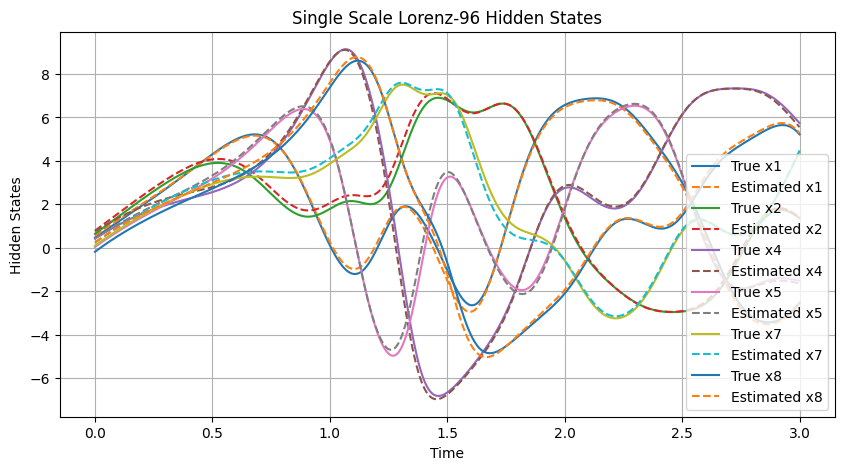

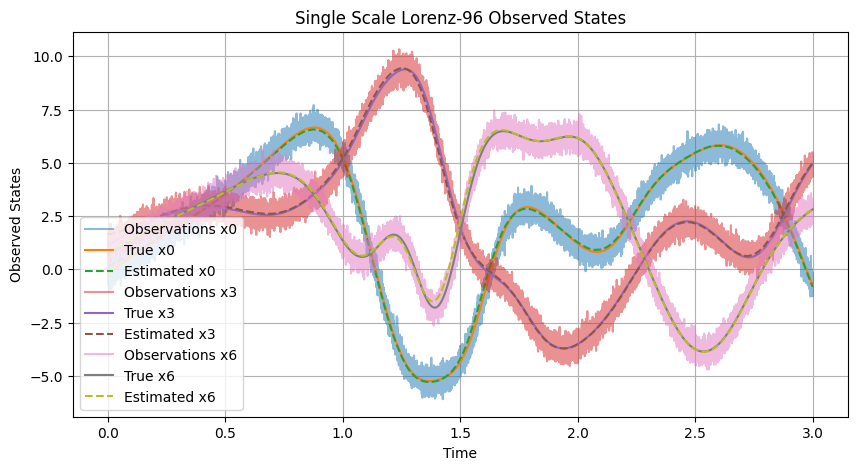

In [43]:

plt.figure(figsize=(10,5))
for i in range(min(6, len(hid_idx))):
    plt.plot(t_vals, x_traj[:, hid_idx[i]], label=f'True x{hid_idx[i]}')
    plt.plot(t_vals, uII_est[i], '--', label=f'Estimated x{hid_idx[i]}')
plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.legend()
plt.title("Single Scale Lorenz-96 Hidden States")
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
for i in range(min(6, len(obs_idx))):
    plt.plot(t_vals, uI_traj[:, i], label=f'Observations x{obs_idx[i]}', alpha=0.5)
    plt.plot(t_vals, x_traj[:, obs_idx[i]], label=f'True x{obs_idx[i]}')
    plt.plot(t_vals, uI_est[i], '--', label=f'Estimated x{obs_idx[i]}')
plt.xlabel("Time")
plt.ylabel("Observed States")
plt.legend()
plt.title("Single Scale Lorenz-96 Observed States")
plt.grid()
plt.show()



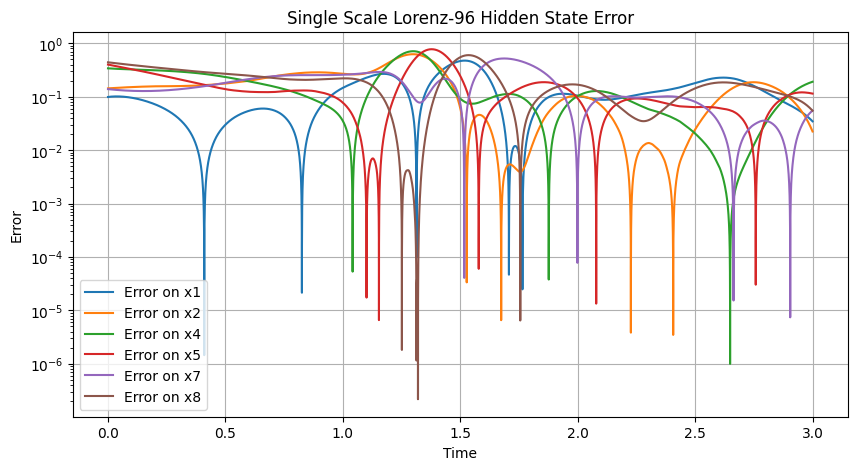

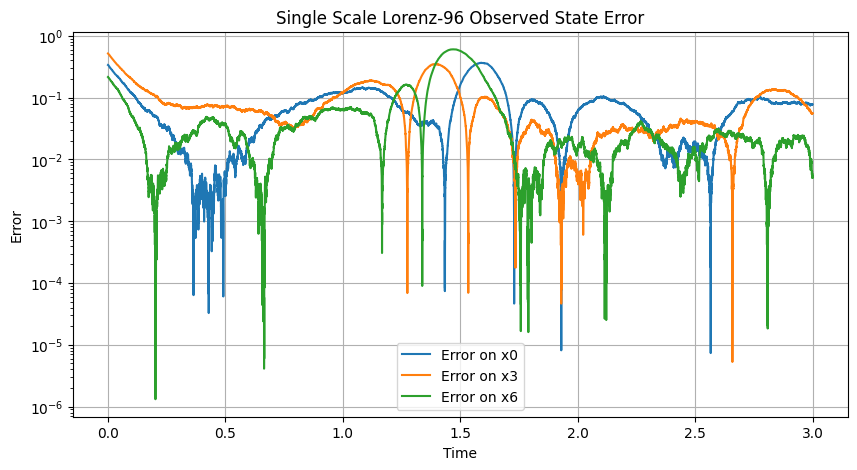

In [45]:

plt.figure(figsize=(10,5))
for i in range(min(6, len(hid_idx))):
    plt.semilogy(t_vals, abs(x_traj[:, hid_idx[i]] - uII_est[i]), label=f'Error on x{hid_idx[i]}')
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.title("Single Scale Lorenz-96 Hidden State Error")
plt.grid()
plt.show()


plt.figure(figsize=(10,5))
for i in range(min(6, len(obs_idx))):
    plt.semilogy(t_vals, abs(x_traj[:, obs_idx[i]] - uI_est[i]), label=f'Error on x{obs_idx[i]}')
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.title("Single Scale Lorenz-96 Observed State Error")
plt.grid()
plt.show()

## Multiscale

In [46]:
def lorenz96_multiscale(u, v, dt, hc, hv, eps, F = 8):
    N,J = v.shape
    du = np.zeros(N)
    for i in range(N):
        du[i] = (u[(i+1)%N] - u[i-2]) * u[i-1] - u[i] + F -(hc/J)*np.sum(v[i])
    dv = np.zeros((N,J))
    for i in range(N):
        for j in range(J):
            dv[i,j] = (1/eps)*(hv*u[i] + v[i,(j+1)%J]*(v[i,(j-1)%J] - v[i,(j+2)%J]) - v[i,j])

    return u+ dt*du, v + dt*dv


In [47]:
np.seterr(over='ignore', divide='ignore', invalid='ignore')
def kb_nudging(d_uI, d_uII, t_span, uI, uII_0, obs_idx, hid_idx, R0=None, SigmaI=None, SigmaII=None,dt = None, k = 10):
    """ Implementation of dynamic nudging for conditionally Gaussian systems

        Args:
            d_uI: function that returns the observation derivative given the state and input
            d_uII: function that returns the unknown state derivative given the state and input
            t_span: time span for the simulation
            uI: observed state
            uII_0: initial unknown state
            R0: initial covariance matrix (optional)
            SigmaI: process noise covariance matrix (optional)
            SigmaII: measurement noise covariance matrix (optional)
            dt: time step (optional, defaults to None, which will be calculated based on the length of x and t_span)
            k: nudging constant toward observations
        Returns:
            A dictionary containing:
                - t: time values
                - uII: estimated state values
                - R: covariance matrix values
    """
    if SigmaII is None:
    #     Sigma2 = SigmaII@SigmaII.T
    # else: 
        Sigma2 = np.zeros((d, d))
    else:
        Sigma2 = SigmaII@SigmaII.T
        # Sigma2 = SigmaII
    t0, tf = t_span
    n = len(uI)
    d1 = len(uI[0])
    d = len(uII_0)
    S = d + d1
    assert len(obs_idx) == d1, "Length of obs_idx must match length of uI"
    assert len(hid_idx) == d, "Length of hid_idx must match length of uII_0"
    assert obs_idx.min() >= 0 and obs_idx.max() < S, "obs_idx out of bounds"
    assert hid_idx.min() >= 0 and hid_idx.max() < S, "hid_idx out of bounds"
    assert set(obs_idx).isdisjoint(set(hid_idx)), "obs_idx and hid_idx overlap! They must be disjoint"
    # sizes
    assert len(obs_idx) == d1, f"len(obs_idx) ({len(obs_idx)}) != d1 ({d1})"
    assert len(hid_idx) == d, f"len(hid_idx) ({len(hid_idx)}) != d ({d})"
    t_vals = np.linspace(t0, tf, n)
    dt = (tf - t0) / (n-1) if dt is None else dt

    u = np.zeros((S,n))
    u[obs_idx,0] = uI[0]
    u[hid_idx,0] = uII_0
    R = np.zeros((n, d, d))
    R[0] = np.eye(d) if R0 is None else R0

    if SigmaI is not None:
        sst = SigmaI@SigmaI.T
        Sig_inv = np.linalg.inv(SigmaI + 1 * np.eye(SigmaI.shape[0]))
    else: 
        Sig_inv = np.zeros((len(uI[0]), len(uI[0])))
    assert np.all(np.isfinite(SigmaII)), "SigmaII has NaNs or Infs!"

    obs = uI.copy()

    for i in tqdm(range(1, n)):
        # R_inv = np.linalg.inv(R[i-1])
        # diag_inv = np.diag(R_inv)

        K_nudging = np.zeros(S)

        u_prev = u[:,i-1].copy()

        # nudging on observations
        K_nudging[obs_idx] = k
        K_nudging[hid_idx] = 0.0
        Hu = u_prev.copy()
        Hu[hid_idx] = 0.0
        obs = Hu.copy()
        obs[obs_idx] = uI[i-1]

        duI = d_uI(t_vals[i-1],u_prev[obs_idx],u_prev[hid_idx])
        duII = d_uII(t_vals[i-1],u_prev[obs_idx],u_prev[hid_idx])

        F = np.zeros(S)
        F[obs_idx] = duI
        F[hid_idx] = duII

        u[:,i] = u[:,i-1] + dt*(F + K_nudging*(obs - Hu))

        # CGKF on hidden variables
        A0,A1 = extract_terms(d_uI, t_vals[i-1], u_prev[obs_idx], u_prev[hid_idx])
        a0, a1 = extract_terms(d_uII, t_vals[i-1], u_prev[obs_idx], u_prev[hid_idx])
        # duI = d_uI(t_vals[i-1],u[obs_idx,i-1],u[hid_idx,i-1])

        # duI = (uI[i] - uI[i-1])/dt
        innovation = duI - (A0 + (A1 @ u_prev[hid_idx]))
        
        K = (R[i-1] @ A1.T) @ Sig_inv

        u[hid_idx,i] = u[hid_idx,i-1] + dt*((a1@u_prev[hid_idx] + a0) + (K @ innovation))
        R[i] = R[i-1] + (a1@R[i-1] + R[i-1]@ a1.T  + Sigma2 - R[i-1]@A1.T@Sig_inv@A1@R[i-1])*dt
        R[i] = 0.5*(R[i] + R[i].T)
        eigvals = np.linalg.eigvalsh(R[i])
        floor = 1e-8
        if np.min(eigvals) < floor:
            R[i] += np.eye(d)*(floor - np.min(eigvals))

            print(f"Adjusted R at step {i} to maintain positive definiteness")

        if np.isnan(R).any():
            print(f"NaN detected at step {i}, filtering failed")

    return {"t": t_vals, "uI": u[obs_idx,:], "uII": u[hid_idx, :], "R": R}

In [71]:

N = 4
J = 8
F = 8
T = 6
hc = 1
hv = .5
n = 20000
eps = 1
x = np.random.randn(N)  # initial condition
dt = T / (n-1)

# generate true system
X_true = .5*np.random.randn(N)
Y_true = .5*np.random.randn(N,J)
X_traj = np.zeros((n,N))
Y_traj = np.zeros((n,N,J))
X_traj[0] = X_true
Y_traj[0] = Y_true
for i in range(1,n):
    X_traj[i],Y_traj[i]  = lorenz96_multiscale(X_traj[i-1], Y_traj[i-1],dt,hc,hv,eps,F)
    # X_traj[i] += dt*du
    # Y_traj[i] += dt*dv


obs_idx = np.arange(0,N)         # observe all slow variables
unobs_id = np.setdiff1d(np.arange(N),obs_idx)
hid_idx = np.arange(N,N+N*J)  # hide fast variables

uI_obs = X_traj[:, obs_idx] + 0.5 * np.random.randn(n, len(obs_idx))
 # observed
uII_0 = np.concatenate((X_traj[0,unobs_id],Y_traj[0].flatten()))   # hidden
uII_0 = uII_0 + .1*np.random.randn(len(uII_0))

def f_uI(t, uI, uII, hc = hc, J = J, F=8):
    """Derivative of slow, observed variables."""
    N_unobs = len(unobs_id)
    N = len(uI) + N_unobs
    slow_vars = np.zeros(N)
    slow_vars[obs_idx] = uI
    slow_vars[unobs_id] = uII[:N_unobs]
    du = np.zeros_like(uI)
    fast_vars = uII[N_unobs:].reshape((N,J))
    for k in range(len(uI)):
        i = obs_idx[k]
        du[k] = (slow_vars[(i+1)%N] - slow_vars[i-2]) * slow_vars[i-1] - slow_vars[i] + F -(hc/J)*np.sum(fast_vars[i])
    return du

def f_uII(t, uI, uII, hv = hv, J = J, eps = eps, F=8):
    """Derivative of fast, hidden variables and unobserved slow variables."""
    N_unobs = len(unobs_id)
    N = len(uI) + N_unobs
    slow_vars = np.zeros(N)
    slow_vars[obs_idx] = uI
    slow_vars[unobs_id] = uII[:N_unobs]
    dv = np.zeros_like(uII)
    fast_vars = uII[N_unobs:].reshape((N,J))
    for k,i in enumerate(unobs_id):
        dv[k] = (slow_vars[(i+1)%N] - slow_vars[i-2]) * slow_vars[i-1] - slow_vars[i] + F -(hc/J)*np.sum(fast_vars[i])

    for i in range(N):
        for j in range(J):
            dv[N_unobs + (i*J) + j] = (1/eps)*(hv*slow_vars[i] + fast_vars[i,(j+1)%J]*(fast_vars[i,j-1] - fast_vars[i,(j+2)%J]) - fast_vars[i,j])

    return dv.flatten()

# Simulation parameters
t_span = (0, T)
t =  np.linspace(t_span[0], t_span[1], n)

N_unobs = len(unobs_id)
N_fast = len(hid_idx)

R0 = np.zeros((N_unobs + N_fast, N_unobs + N_fast))
# unobserved slow
R0[:N_unobs, :N_unobs] = .5*np.eye(N_unobs)
# fast variables (scaled)
R0[N_unobs:, N_unobs:] = 2*np.eye(N_fast)
# mean_var_slow = np.var(X_traj, axis=0).mean()
# gamma_fast = 0.1  # start small if fast variables are faster
# SigmaII = gamma_fast * mean_var_slow * np.eye(len(uII_0))

uII_0 = uII_0.astype(float)
SigmaII = 0.05 * np.eye(len(uII_0), dtype=float)

results = kb_nudging(
    d_uI=lambda t,uI,uII: f_uI(t,uI,uII),
    d_uII=lambda t,uI,uII: f_uII(t,uI,uII),
    t_span=t_span,
    uI=uI_obs,
    uII_0=uII_0,
    obs_idx=obs_idx,
    hid_idx=hid_idx,
    R0=R0,
    SigmaI=0.1*np.eye(len(obs_idx)),
    SigmaII=SigmaII,
    dt=dt, k = 10
)

uII_est = results['uII']
uI_est = results['uI']

t_vals = results['t']

y_traj = Y_traj.reshape(n,N*J).T

uII_est = results['uII']
t_vals = results['t']


100%|██████████| 19999/19999 [01:31<00:00, 219.45it/s]


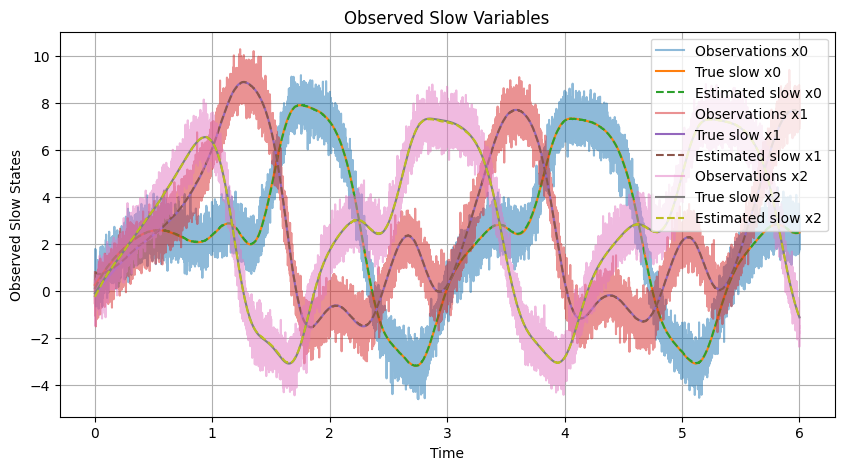

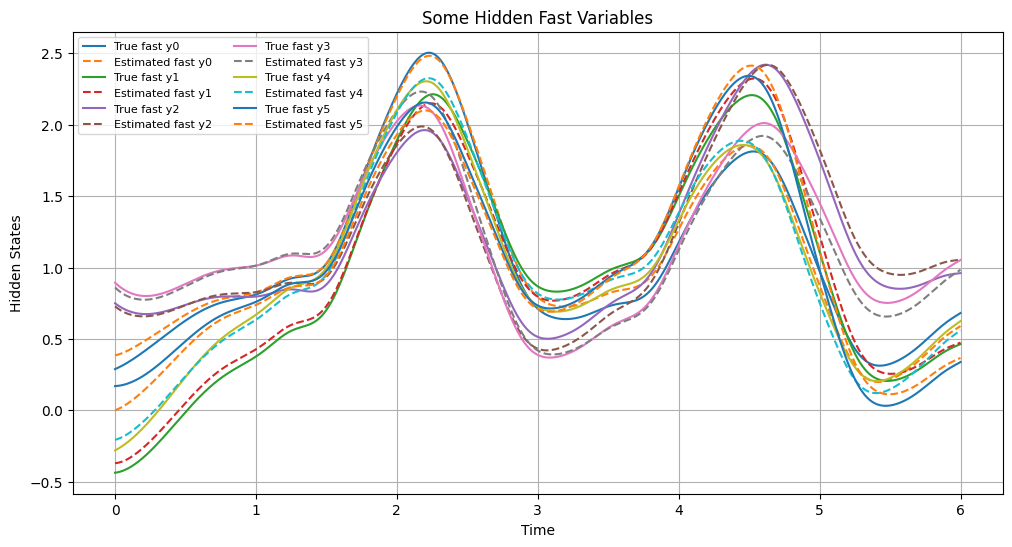

In [72]:

# Plot slow variables
plt.figure(figsize=(10,5))
for i, idx in enumerate(obs_idx[:3]):
    plt.plot(t_vals, uI_obs[:, i], label=f'Observations x{idx}', alpha=0.5)
    plt.plot(t_vals, X_traj[:, idx], label=f'True slow x{idx}')
    plt.plot(t_vals, uI_est[i], '--', label=f'Estimated slow x{idx}')
plt.xlabel("Time")
plt.ylabel("Observed Slow States")
plt.legend()
plt.title("Observed Slow Variables")
plt.grid()
plt.show()

plt.figure(figsize=(12,6))

# Plot first few fast variables
num_fast_to_plot = 6
fast_start_idx = len(unobs_id)
for i in range(num_fast_to_plot):
    plt.plot(t_vals, Y_traj[:, i//J, i%J], label=f'True fast y{i}')
    plt.plot(t_vals, uII_est[fast_start_idx + i], '--', label=f'Estimated fast y{i}')

plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.title("Some Hidden Fast Variables")
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.show()




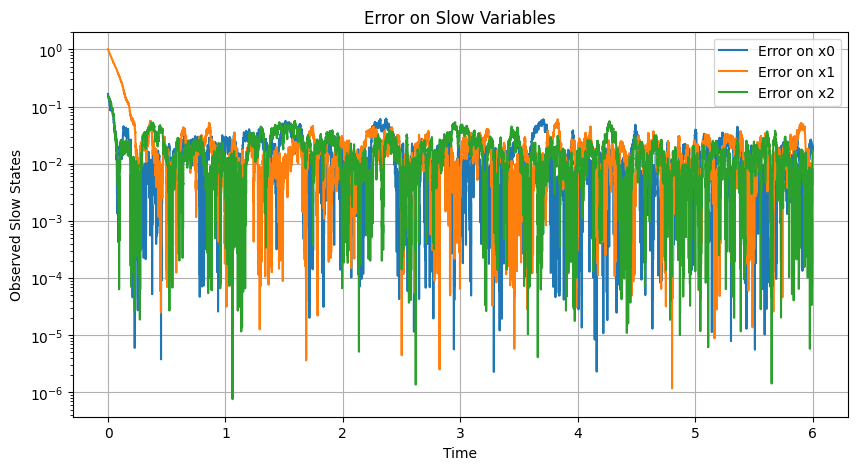

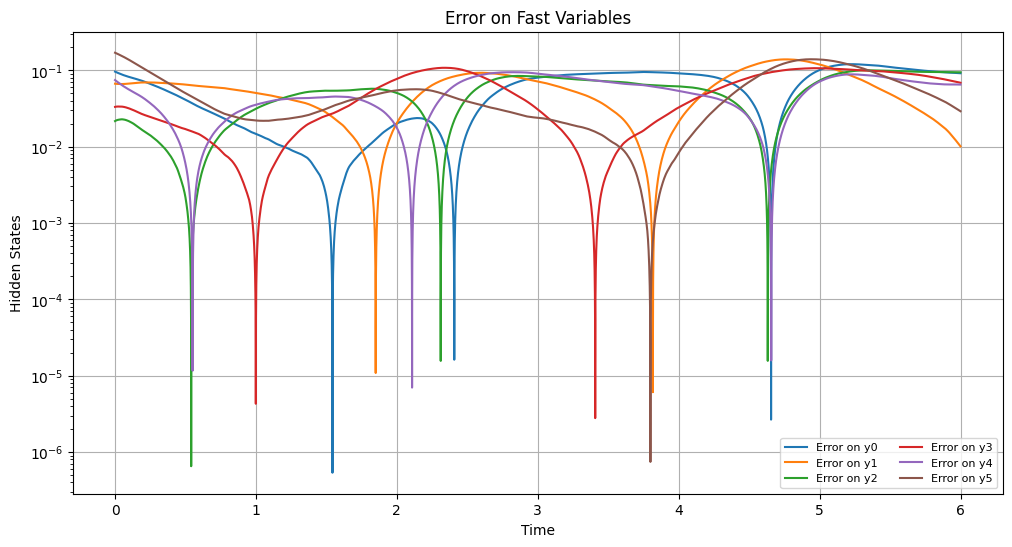

In [73]:

# Plot slow variables
plt.figure(figsize=(10,5))
for i, idx in enumerate(obs_idx[:3]):
    plt.semilogy(t_vals, np.abs(uI_est[i] - X_traj[:, idx]), label=f'Error on x{idx}')
plt.xlabel("Time")
plt.ylabel("Observed Slow States")
plt.legend()
plt.title("Error on Slow Variables")
plt.grid()
plt.show()

plt.figure(figsize=(12,6))

# Plot first few fast variables
num_fast_to_plot = 6
fast_start_idx = len(unobs_id)
for i in range(num_fast_to_plot):
    plt.semilogy(t_vals, np.abs(uII_est[fast_start_idx + i] - Y_traj[:, i//J, i%J]), label=f'Error on y{i}')

plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.title("Error on Fast Variables")
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.show()